# Variational Auto-encoder

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data 
from collections import defaultdict
from tqdm import tqdm
import sys
sys.path.append('../python/')
%load_ext autoreload

tf.logging.set_verbosity(tf.logging.ERROR)
tf.logging.set_verbosity(tf.logging.WARN)
tf.logging.set_verbosity(tf.logging.DEBUG)
tf.logging.set_verbosity(tf.logging.FATAL)
import warnings
warnings.filterwarnings("ignore", module="matplotlib")

np.random.seed(1234)
tf.set_random_seed(1234)

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
X_train, X_test = mnist.train, mnist.test

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
%autoreload
from vae import VAE, LogDerTrickVAE, VIMCOVAE, NVILVAE, MuPropVAE
from utils import train, get_gradient_mean_and_std

In [4]:
n_samples = mnist.train.num_examples
n_input = 784
n_z = 20
n_ary = 8
batch_size = 128
weights_save_step = 50
save_path = 'saved_weights/'

network_architecture = {
    'encoder': {
        'h1': (n_input, 80), 
        'h2': (80, n_ary*80), 
        'out_mean': (n_ary*80, n_ary*n_z)
    }, 
    'decoder': {
        'h1': (n_ary*n_z, 80), 
        'h2': (80, 80),
        'out_mean': (80, n_input)
    }
}

### The comparison of all methods

In [5]:
training_epochs = 401
display_step = 1
save_weights = True

In [6]:
vaes = [LogDerTrickVAE, NVILVAE, VIMCOVAE, MuPropVAE]
learning_rates = [1e-4, 1e-4, 1e-4, 1e-4]
vaes = [vae(n_input, n_z, network_architecture, learning_rate, n_ary=n_ary) 
        for vae, learning_rate in zip(vaes, learning_rates)]
names = [str(vae) for vae in vaes]

LogDerTrickVAE: train cost = 119.982978821, test cost = 119.505653381
NVILVAE: train cost = 101.564750671, test cost = 101.001121521
VIMCOVAE: train cost = 91.709495544, test cost = 91.479820251
MuPropVAE: train cost = 110.551223755, test cost = 109.589202881


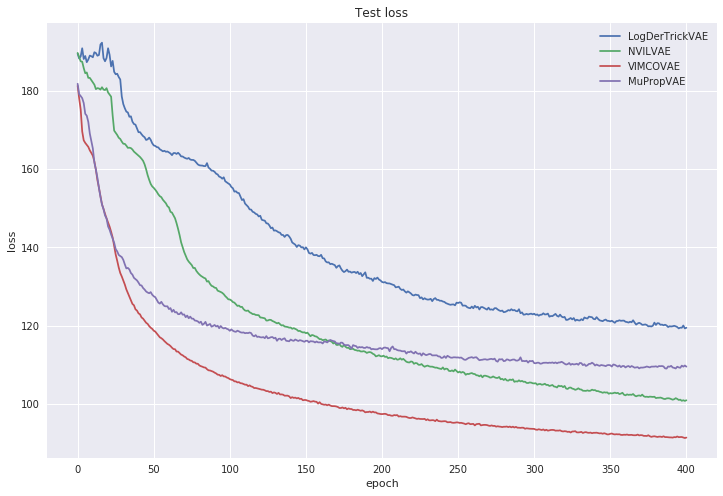

100%|██████████| 401/401 [5:30:42<00:00, 51.99s/it]


In [7]:
train(vaes, names, X_train, X_test, n_samples, batch_size, training_epochs, 
      display_step, weights_save_step, save_weights, save_path)

### The comparison of the gradient estimator variance of each method

In [9]:
vaes = [LogDerTrickVAE, NVILVAE, VIMCOVAE, MuPropVAE]
learning_rates = [1e-4, 1e-4, 1e-4, 1e-4]
vaes = [vae(n_input, n_z, network_architecture, learning_rate, n_ary=n_ary) 
        for vae, learning_rate in zip(vaes, learning_rates)]
names = [str(vae) for vae in vaes]

In [10]:
batch_xs, _ = X_train.next_batch(batch_size)
n_iterations = 100

In [11]:
encoder_stds = defaultdict(lambda: defaultdict(list))
decoder_stds = defaultdict(lambda: defaultdict(list))

for weights_name in tqdm(names):
    for name, vae in zip(names, vaes):
        if name == 'NVILVAE' and weights_name != 'NVILVAE':
            continue
        for saved_index in range(1, training_epochs+1, weights_save_step):
            vae.restore_weights(save_path + weights_name + '_{}'.format(saved_index))
            _, encoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'encoder')
            _, decoder_std = get_gradient_mean_and_std(vae, batch_xs, n_iterations, 'decoder')
            encoder_stds[weights_name][name].append(encoder_std)
            decoder_stds[weights_name][name].append(decoder_std)

100%|██████████| 4/4 [05:54<00:00, 85.66s/it]


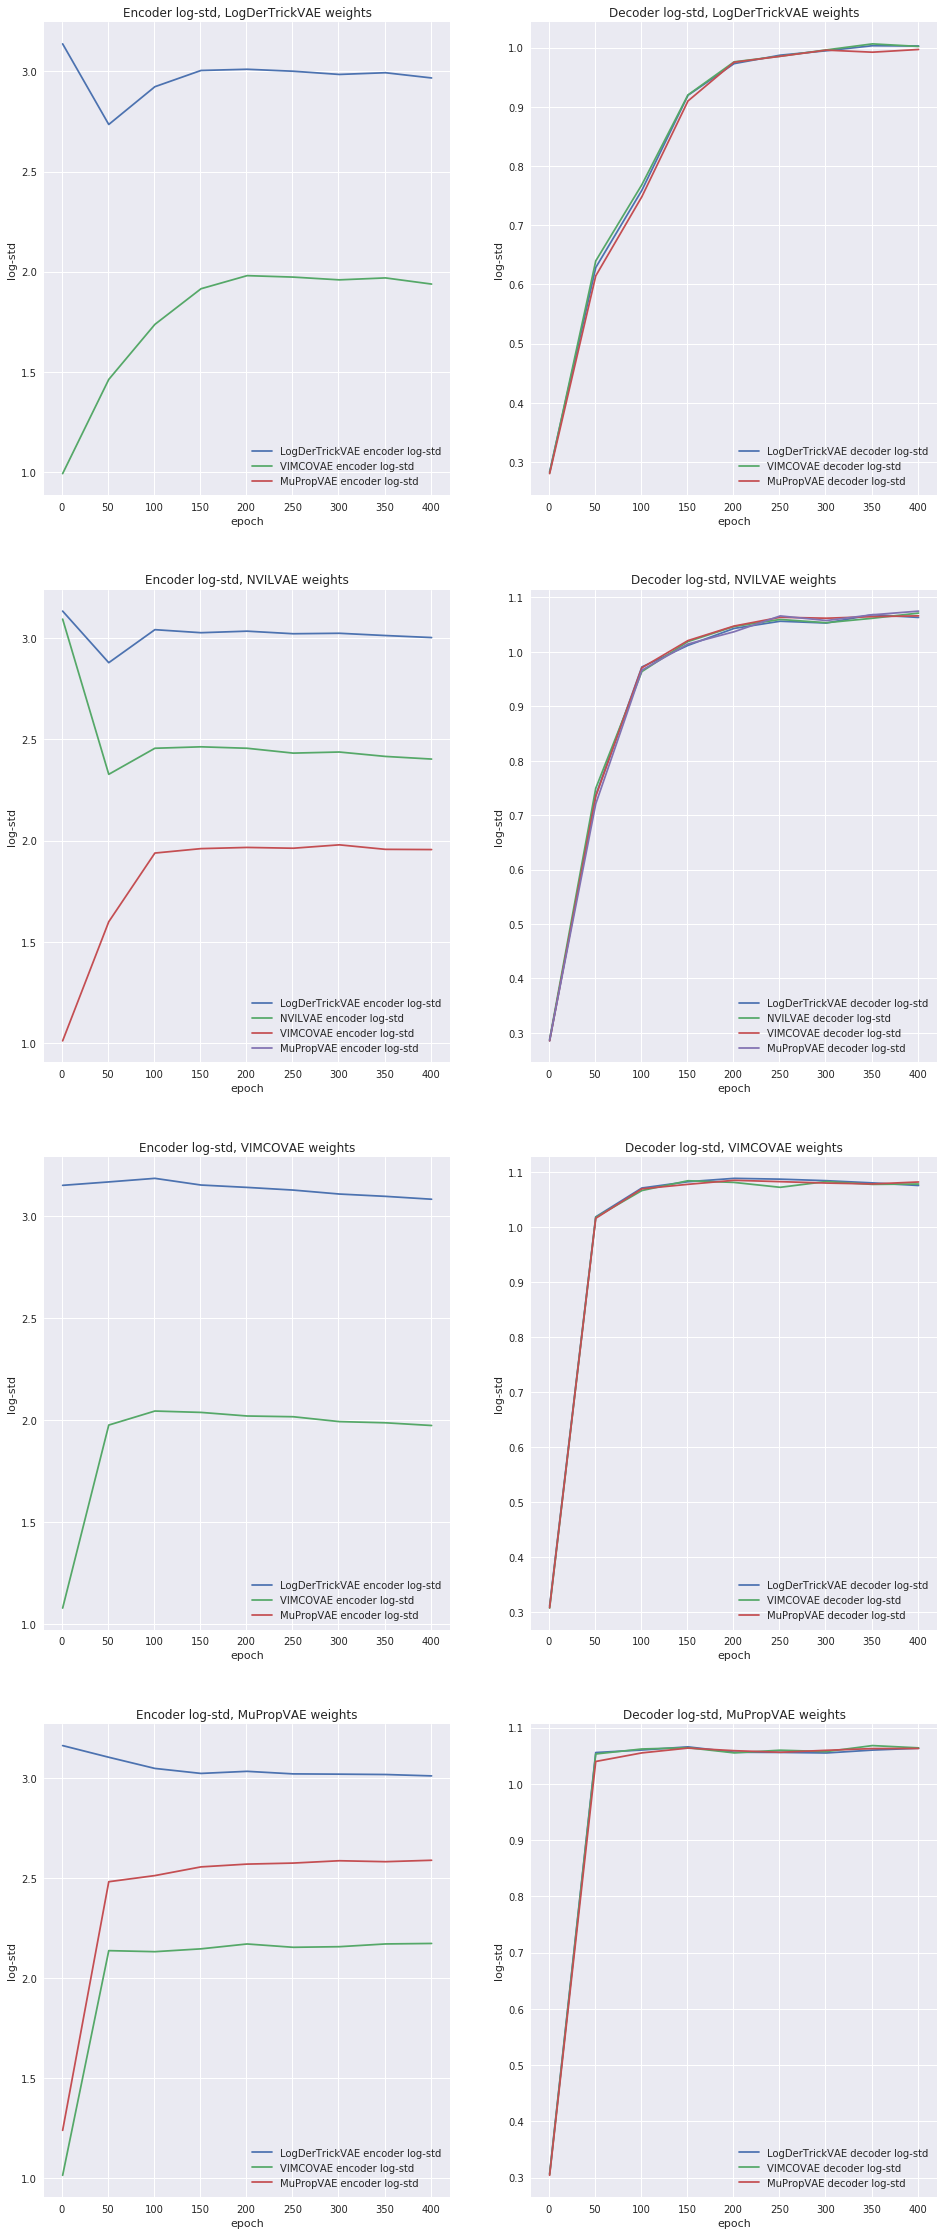

In [13]:
n_vaes = len(vaes)
weights_range = np.arange(1, training_epochs+1, weights_save_step)

fig, axes = plt.subplots(n_vaes, 2, figsize=(16, 40))
for idx, weights_name in enumerate(names):
    for name in names:
        if name == 'NVILVAE' and weights_name != 'NVILVAE':
            continue
        axes[idx][0].plot(weights_range, np.log10(encoder_stds[weights_name][name]), 
                          label='{} encoder log-std'.format(name))
        axes[idx][1].plot(weights_range, np.log10(decoder_stds[weights_name][name]), 
                          label='{} decoder log-std'.format(name))
    axes[idx][0].set_title('Encoder log-std, {} weights'.format(weights_name))
    axes[idx][0].set_xlabel('epoch')
    axes[idx][0].set_ylabel('log-std')
    axes[idx][0].legend(loc='best')
    
    axes[idx][1].set_title('Decoder log-std, {} weights'.format(weights_name))
    axes[idx][1].set_xlabel('epoch')
    axes[idx][1].set_ylabel('log-std')
    axes[idx][1].legend(loc='best')
plt.show()